## Chaque ligne du csv est une arête du graphe 

In [2]:
import pandas as pd 
import numpy as np
import networkx as nx 
import torch
from torch_geometric.data import Data
from torch_geometric.nn import VGAE, GCNConv
from torch_geometric.nn import InnerProductDecoder
import scipy.sparse as sp
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from datetime import datetime

In [3]:
train_fraud = pd.read_csv("../data/SimulatedfraudTrain.csv")

In [6]:
# ==================== FEATURE ENGINEERING ====================

# Identifier la colonne de date (peut avoir différents noms)
date_col = None
for col in train_fraud.columns:
    if 'trans' in col.lower() and ('date' in col.lower() or 'time' in col.lower()):
        date_col = col
        break

if date_col is None:
    print("Colonne de date non trouvée. Colonnes disponibles:")
    print(train_fraud.columns.tolist())
    date_col = 'trans_date_trans_time'  # Valeur par défaut

print(f" Colonne de date utilisée: {date_col}")

# Convertir en datetime
train_fraud['trans_datetime'] = pd.to_datetime(train_fraud[date_col])
train_fraud['hour'] = train_fraud['trans_datetime'].dt.hour
train_fraud['day_of_week'] = train_fraud['trans_datetime'].dt.dayofweek
train_fraud['day_of_month'] = train_fraud['trans_datetime'].dt.day
train_fraud['is_weekend'] = train_fraud['day_of_week'].isin([5, 6]).astype(int)

# Encoder la catégorie
le_category = LabelEncoder()
train_fraud['category_encoded'] = le_category.fit_transform(train_fraud['category'])

print(" Catégories uniques:")
print(f"Nombre de catégories: {train_fraud['category'].nunique()}")
print("\nTop 10 catégories:")
print(train_fraud['category'].value_counts().head(10))

# Analyser les distances géographiques
print(" Variables géographiques disponibles:")
geo_cols = ['city', 'state', 'street', 'lat', 'long']
for col in geo_cols:
    if col in train_fraud.columns:
        print(f"  - {col}: {train_fraud[col].nunique()} valeurs uniques")

 Colonne de date utilisée: trans_date_trans_time
 Catégories uniques:
Nombre de catégories: 14

Top 10 catégories:
category
gas_transport     131659
grocery_pos       123638
home              123115
shopping_pos      116672
kids_pets         113035
shopping_net       97543
entertainment      94014
food_dining        91461
personal_care      90758
health_fitness     85879
Name: count, dtype: int64
 Variables géographiques disponibles:
  - city: 894 valeurs uniques
  - state: 51 valeurs uniques
  - street: 983 valeurs uniques
  - lat: 968 valeurs uniques
  - long: 969 valeurs uniques


In [10]:
# création des noeuds 
# Cartes
cards = train_fraud['cc_num'].astype(str).unique()
card2id = {c: i for i, c in enumerate(cards)}

# Marchands
merchants = train_fraud['merchant'].unique()
merchant2id = {m: i + len(card2id) for i, m in enumerate(merchants)}
print(merchant2id)
num_nodes = len(card2id) + len(merchant2id)
print("Nombre total de nœuds :", num_nodes)


{'fraud_Rippin, Kub and Mann': 983, 'fraud_Heller, Gutmann and Zieme': 984, 'fraud_Lind-Buckridge': 985, 'fraud_Kutch, Hermiston and Farrell': 986, 'fraud_Keeling-Crist': 987, 'fraud_Stroman, Hudson and Erdman': 988, 'fraud_Rowe-Vandervort': 989, 'fraud_Corwin-Collins': 990, 'fraud_Herzog Ltd': 991, 'fraud_Schoen, Kuphal and Nitzsche': 992, 'fraud_Rutherford-Mertz': 993, 'fraud_Kerluke-Abshire': 994, 'fraud_Lockman Ltd': 995, 'fraud_Kiehn Inc': 996, 'fraud_Beier-Hyatt': 997, 'fraud_Schmidt and Sons': 998, 'fraud_Lebsack and Sons': 999, 'fraud_Mayert Group': 1000, 'fraud_Konopelski, Schneider and Hartmann': 1001, 'fraud_Schultz, Simonis and Little': 1002, 'fraud_Bauch-Raynor': 1003, 'fraud_Harris Inc': 1004, 'fraud_Kling-Grant': 1005, 'fraud_Pacocha-Bauch': 1006, 'fraud_Lesch Ltd': 1007, 'fraud_Kunde-Sanford': 1008, "fraud_Deckow-O'Conner": 1009, 'fraud_Bruen-Yost': 1010, 'fraud_Kunze Inc': 1011, 'fraud_Nitzsche, Kessler and Wolff': 1012, 'fraud_Kihn, Abernathy and Douglas': 1013, 'frau

In [ ]:
#créer les arêtes (card <--> marchand)

edge_data = train_fraud.groupby(['cc_num', 'merchant']).agg({
    'amt': ['sum', 'mean', 'count'],
    'is_fraud': 'max'  # is_fraud est utilisé pour labels seulement
}).reset_index()

edges = []
edge_labels = []

for _, row in edge_data.iterrows():
    card_id = card2id[str(row[('cc_num', '')])]
    merchant_id = merchant2id[row[('merchant', '')]]
    edges.append([card_id, merchant_id])
    edge_labels.append(row[('is_fraud', 'max')])

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

print(f" Arêtes:")
print(f"  Avant agrégation: {len(train_fraud):,} transactions")
print(f"  Après agrégation: {len(edges):,} paires uniques")
print(f"  Réduction: {(1 - len(edges)/len(train_fraud))*100:.1f}%")

# Bidirectionnel
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
edge_labels = torch.tensor(edge_labels + edge_labels, dtype=torch.float)

print(f"  Après bidirection: {edge_index.shape[1]:,} arêtes")



🔗 Arêtes:
  Avant agrégation: 1,296,675 transactions
  Après agrégation: 479,072 paires uniques
  Réduction: 63.1%
  Après bidirection: 958,144 arêtes


In [19]:
# construire les features des noeuds 

# features cartes

card_features = train_fraud.groupby('cc_num').agg({
    # Montants
    'amt': ['count', 'sum', 'mean', 'std', 'min', 'max'],
    
    # Temporelles
    'hour': ['mean', 'std'],
    'is_weekend': 'mean',
    'day_of_week': lambda x: x.mode()[0] if len(x.mode()) > 0 else 0,
    
    # Catégories (diversité)
    'category': 'nunique',
    'merchant': 'nunique',
    
    # Géographiques
    'state': 'nunique',
    'city': 'nunique'
}).fillna(0)

# Aplatir les colonnes multi-niveaux
card_features.columns = ['_'.join(col).strip() for col in card_features.columns]

print(" Features des cartes:")
print(card_features.columns.tolist())
print(f"Dimension: {card_features.shape}")
print(" Exemple:")
print(card_features.head())

# features marchands 
merchant_features = train_fraud.groupby('merchant').agg({
    # Montants
    'amt': ['count', 'sum', 'mean', 'std', 'min', 'max'],
    
    # Temporelles
    'hour': ['mean', 'std'],
    'is_weekend': 'mean',
    
    # Diversité clients
    'cc_num': 'nunique',
    
    # Catégorie dominante
    'category': lambda x: le_category.transform([x.mode()[0]])[0] if len(x.mode()) > 0 else 0,
    
    # Géographique
    #'state': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',
    'city': 'nunique'
}).fillna(0)



merchant_features.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col 
                             for col in merchant_features.columns]

print(" Features des marchands:")
print(merchant_features.columns.tolist())
print(f"Dimension: {merchant_features.shape}")
print(" Exemple:")
print(merchant_features.head())


 Features des cartes:
['amt_count', 'amt_sum', 'amt_mean', 'amt_std', 'amt_min', 'amt_max', 'hour_mean', 'hour_std', 'is_weekend_mean', 'day_of_week_<lambda>', 'category_nunique', 'merchant_nunique', 'state_nunique', 'city_nunique']
Dimension: (983, 14)
 Exemple:
             amt_count    amt_sum    amt_mean      amt_std  amt_min   amt_max  \
cc_num                                                                          
60416207185       1518   85043.47   56.023366   122.632635     1.02   3075.09   
60422928733       1531  105640.20   69.000784   102.681962     1.04   1290.37   
60423098130        510   58673.63  115.046333  1202.988005     1.01  27119.77   
60427851591        528   59129.61  111.987898   143.310653     8.86   1164.36   
60487002085        496   25160.11   50.726028    65.843969     1.02    750.39   

             hour_mean  hour_std  is_weekend_mean  day_of_week_<lambda>  \
cc_num                                                                    
60416207185  13.68

In [ ]:
###################################################################################################
### Feature Supplémentaire avancée 


# Pour les cartes : Variabilité temporelle
# card_time_features = train_fraud.groupby('cc_num').apply(
#     lambda x: pd.Series({
#         'hour_range': x['hour'].max() - x['hour'].min(),
#         'active_days': x['trans_datetime'].dt.date.nunique(),
#         'avg_daily_transactions': len(x) / max(1, x['trans_datetime'].dt.date.nunique()),
#         'night_transactions_pct': (x['hour'].between(0, 6).sum() / len(x)) * 100 if len(x) > 0 else 0
#     })
# ).fillna(0)

# print(" Features temporelles avancées pour cartes:")
# print(card_time_features.head())

# # Pour les marchands : Patterns de montants
# merchant_amt_features = train_fraud.groupby('merchant').apply(
#     lambda x: pd.Series({
#         'amt_cv': (x['amt'].std() / x['amt'].mean()) if x['amt'].mean() > 0 else 0,  # Coef variation
#         'amt_range': x['amt'].max() - x['amt'].min(),
#         'high_amt_pct': (x['amt'] > x['amt'].quantile(0.75)).sum() / len(x) * 100
#     })
# ).fillna(0)

# print(" Features montants avancées pour marchands:")
# print(merchant_amt_features.head())

/tmp/ipykernel_102305/728553644.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  card_time_features = train_fraud.groupby('cc_num').apply(


 Features temporelles avancées pour cartes:
             hour_range  active_days  avg_daily_transactions  \
cc_num                                                         
60416207185        23.0        498.0                3.048193   
60422928733        23.0        484.0                3.163223   
60423098130        23.0        318.0                1.603774   
60427851591        23.0        318.0                1.660377   
60487002085        23.0        319.0                1.554859   

             night_transactions_pct  
cc_num                               
60416207185               17.720685  
60422928733               35.009798  
60423098130               27.254902  
60427851591               25.189394  
60487002085               19.758065  
 Features montants avancées pour marchands:
                                    amt_cv  amt_range  high_amt_pct
merchant                                                           
fraud_Abbott-Rogahn               1.074634     654.58     25.

/tmp/ipykernel_102305/728553644.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merchant_amt_features = train_fraud.groupby('merchant').apply(


In [20]:
###############################################################################################################################
# fusion des features + normalisation

# Combiner toutes les features pour cartes
card_features_final = pd.concat([card_features], axis=1).fillna(0)

# Combiner pour marchands
merchant_features_final = pd.concat([merchant_features], axis=1).fillna(0)

print(f" Features finales cartes: {card_features_final.shape[1]} colonnes")
print(f" Features finales marchands: {merchant_features_final.shape[1]} colonnes")

# Aligner les dimensions (padding ou sélection)
n_card_features = card_features_final.shape[1]
n_merchant_features = merchant_features_final.shape[1]

print(f" Alignement des dimensions:")
print(f"  Cartes: {n_card_features} features")
print(f"  Marchands: {n_merchant_features} features")

if n_card_features != n_merchant_features:
    print("  Les dimensions diffèrent. Options:")
    print("  1. Padding avec des zéros (simple mais sous-optimal)")
    print("  2. Sélectionner features communes (perte d'info)")
    print("  3. Utiliser un graphe hétérogène (recommandé)")
    
    # Option 1: Padding
    max_features = max(n_card_features, n_merchant_features)
    
    if n_card_features < max_features:
        padding = pd.DataFrame(
            0, 
            index=card_features_final.index,
            columns=[f'pad_{i}' for i in range(max_features - n_card_features)]
        )
        card_features_final = pd.concat([card_features_final, padding], axis=1)
    
    if n_merchant_features < max_features:
        padding = pd.DataFrame(
            0,
            index=merchant_features_final.index,
            columns=[f'pad_{i}' for i in range(max_features - n_merchant_features)]
        )
        merchant_features_final = pd.concat([merchant_features_final, padding], axis=1)

# Convertir en arrays
X_cards = card_features_final.values
X_merchants = merchant_features_final.values

# NORMALISATION 
X = np.vstack([X_cards, X_merchants])

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

print(f" Statistiques après normalisation:")
print(f"  Mean: {X_normalized.mean():.6f}")
print(f"  Std: {X_normalized.std():.6f}")
print(f"  Min: {X_normalized.min():.6f}")
print(f"  Max: {X_normalized.max():.6f}")

X_tensor = torch.tensor(X_normalized, dtype=torch.float)

 Features finales cartes: 14 colonnes
 Features finales marchands: 12 colonnes
 Alignement des dimensions:
  Cartes: 14 features
  Marchands: 12 features
  Les dimensions diffèrent. Options:
  1. Padding avec des zéros (simple mais sous-optimal)
  2. Sélectionner features communes (perte d'info)
  3. Utiliser un graphe hétérogène (recommandé)
 Statistiques après normalisation:
  Mean: -0.000000
  Std: 1.000000
  Min: -3.814250
  Max: 12.674216


In [21]:
# création de l'objet graphe qui est l'entrée dans le vgae
data_train = Data(
    x=X_tensor,
    edge_index=edge_index,
    y=edge_labels,  # Labels pour validation
    num_nodes=num_nodes
)

print("\n" + "="*80)
print("GRAPHE FINAL")
print("="*80)
print(data_train)

print(f"""
RÉSUMÉ:
  • Nœuds: {num_nodes:,}
  • Features par nœud: {X_tensor.shape[1]}
  • Arêtes: {edge_index.shape[1]:,}
  • Labels disponibles: {len(edge_labels):,}
  • Pas de data leakage: ✓
  • Features normalisées: ✓
  • Multi-edges agrégées: ✓
""")


GRAPHE FINAL
Data(x=[1676, 14], edge_index=[2, 958144], y=[958144], num_nodes=1676)

RÉSUMÉ:
  • Nœuds: 1,676
  • Features par nœud: 14
  • Arêtes: 958,144
  • Labels disponibles: 958,144
  • Pas de data leakage: ✓
  • Features normalisées: ✓
  • Multi-edges agrégées: ✓



## Application du VGAE 

In [22]:

# création de la matrice adjacente
adj = sp.coo_matrix(
    (np.ones(edge_index.shape[1]),
     (edge_index[0].numpy(), edge_index[1].numpy())),
    shape=(num_nodes, num_nodes)
)


In [24]:
def sparse_to_tuple(sparse_mx):
    """
    Convertit une matrice sparse scipy en tuple (coords, values, shape)
    """
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()

# indice des arêtes
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()

#poids normalisés
    values = sparse_mx.data

#taille de la matrice 
    shape = sparse_mx.shape

    return coords, values, shape


def preprocess_graph(adj):
    """
    Prétraitement du graphe pour VGAE / GCN
    - Ajoute des self-loops
    - Normalise la matrice d'adjacence
    - Retourne une représentation sparse exploitable
    """

    # S'assure que la matrice est en format COO
    adj = sp.coo_matrix(adj)

    # Ajout des self-loops
    adj_ = adj + sp.eye(adj.shape[0])

    # Calcul du degré de chaque nœud
    rowsum = np.array(adj_.sum(1))

    # D^{-1/2}
    degree_mat_inv_sqrt = sp.diags(
        np.power(rowsum, -0.5).flatten()
    )

    # Normalisation symétrique : D^{-1/2} (A + I) D^{-1/2}
    adj_normalized = adj_.dot(degree_mat_inv_sqrt)\
                         .transpose()\
                         .dot(degree_mat_inv_sqrt)\
                         .tocoo()

    return sparse_to_tuple(adj_normalized)


In [26]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        mu = self.conv_mu(x, edge_index)
        logstd = self.conv_logstd(x, edge_index)
        return mu, logstd

# InnerProductDecoder suppose un graphe non dirigé 

# modèle
out_channels = 32
encoder = GCNEncoder(data_train.num_features, out_channels)
model = VGAE(encoder, decoder=InnerProductDecoder())

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(200):
    model.train()
    optimizer.zero_grad()

    z = model.encode(data_train.x, data_train.edge_index)

    loss = model.recon_loss(z, data_train.edge_index)
    loss = loss + model.kl_loss()

    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")



Epoch 0, Loss: 9.9549
Epoch 1, Loss: 6.3030
Epoch 2, Loss: 5.1092
Epoch 3, Loss: 4.6990
Epoch 4, Loss: 4.5636
Epoch 5, Loss: 4.5832
Epoch 6, Loss: 4.5734
Epoch 7, Loss: 4.4942
Epoch 8, Loss: 4.3730
Epoch 9, Loss: 4.3279
Epoch 10, Loss: 4.3712
Epoch 11, Loss: 4.3179
Epoch 12, Loss: 4.3443
Epoch 13, Loss: 4.3367
Epoch 14, Loss: 4.3070
Epoch 15, Loss: 4.2618
Epoch 16, Loss: 4.3248
Epoch 17, Loss: 4.2919
Epoch 18, Loss: 4.2443
Epoch 19, Loss: 4.2851
Epoch 20, Loss: 4.2857
Epoch 21, Loss: 4.2559
Epoch 22, Loss: 4.2701
Epoch 23, Loss: 4.2693
Epoch 24, Loss: 4.2842
Epoch 25, Loss: 4.2836
Epoch 26, Loss: 4.2478
Epoch 27, Loss: 4.2689
Epoch 28, Loss: 4.2876
Epoch 29, Loss: 4.2748
Epoch 30, Loss: 4.2545
Epoch 31, Loss: 4.2165
Epoch 32, Loss: 4.2621
Epoch 33, Loss: 4.2067
Epoch 34, Loss: 4.2127
Epoch 35, Loss: 4.2475
Epoch 36, Loss: 4.2190
Epoch 37, Loss: 4.2311
Epoch 38, Loss: 4.1952
Epoch 39, Loss: 4.2847
Epoch 40, Loss: 4.2721
Epoch 41, Loss: 4.2503
Epoch 42, Loss: 4.2045
Epoch 43, Loss: 4.246

In [27]:
# score d'anomalie 
# récupérer les embeddings
 
model.eval()
with torch.no_grad():
    z = model.encode(data_train.x, data_train.edge_index)

#score de reconstruction des arêtes
def edge_reconstruction_score(z, edge_index):
    src, dst = edge_index
    score = (z[src] * z[dst]).sum(dim=1)
    return score

scores = edge_reconstruction_score(z, data_train.edge_index)

#score par transaction 
train_fraud['recon_score'] = scores[:len(train_fraud)].cpu().numpy()

# détecter les anomalies 
threshold = np.percentile(train_fraud['recon_score'], 5)
train_fraud['is_anomaly'] = train_fraud['recon_score'] < threshold


ValueError: Length of values (958144) does not match length of index (1296675)

In [ ]:


roc_auc_score(
    train_fraud['is_fraud'],
    -train_fraud['recon_score']
)


0.3411079947764689

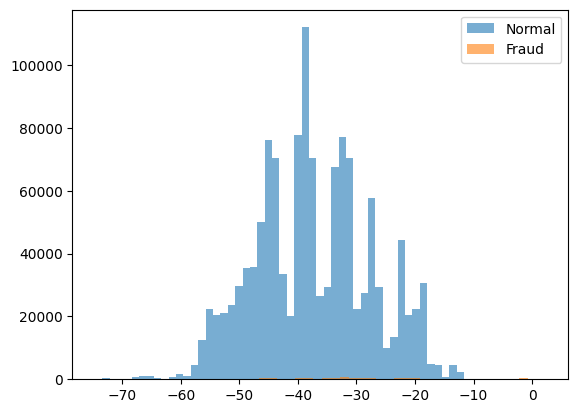

In [ ]:
# visualisation


plt.hist(
    train_fraud.loc[train_fraud.is_fraud == 0, 'recon_score'],
    bins=50, alpha=0.6, label='Normal'
)
plt.hist(
    train_fraud.loc[train_fraud.is_fraud == 1, 'recon_score'],
    bins=50, alpha=0.6, label='Fraud'
)
plt.legend()
plt.show()
